In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
# 将图片展开为多组一维数组,并归一化
def normalize_images(imgs):
    imgs = imgs.reshape(-1,28*28)
    return imgs/255

# 判断是否为可迭代对象
def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False
    
# 将标签转换为one-hot编码
def one_hot_labels(labels):
    '''
    labels: 标签（一维数组）

    numpy 高级索引功能
    以train_labels为行索引，以train_labels为列索引，将one_hot中的元素赋值为1
    '''
    one_hot = np.zeros((labels.size,labels.max()+1))
    one_hot[np.arange(labels.size),labels] = 1

    return one_hot

# 显示图片
def show_img(img,labels,preds,num=0):
    if is_iterable(img):
        plt.imshow(img[num].reshape(28,28),cmap='gray')
        plt.title(f'True:{labels[num]}, Predicted:{preds}')
        plt.colorbar()
        plt.show()
    else:
        plt.imshow(img.reshape(28,28),cmap='gray')
        plt.colorbar()
        plt.show()

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

def print_shape(*args):
    for arg in args:
        name = get_arg_name(arg)
        print(f'{name}',arg.shape)

# 获取变量名
def get_arg_name(arg):
    for name in globals().keys():
        if globals()[name] is arg:
            return name

# 前向传播
def forward_propagation(imgs,w1,b1,w2,b2,shape=False):
    '''
    Args:
        imgs: 图片数据
        w1: 第一层权重
        b1: 第一层偏置
        w2: 第二层权重
        b2: 第二层偏置
    Return:
        z1: 第一层线性输出
        a1: 第一层激活输出
        z2: 第二层线性输出
        a2: 第二层激活输出
    '''
    imgs = imgs.reshape(-1,imgs.shape[-1])
    z1 = np.dot(w1,imgs.T)+b1
    a1 = sigmoid(z1)
    z2 = np.dot(w2,a1) + b2
    a2 = sigmoid(z2)
    if shape:
        print('z1:',z1.shape,'\na1:',a1.shape,'\nz2:',z2.shape,'\na2:',a2.shape)
    return z1,a1,z2,a2

# 后向传播
def backward_propagation(imgs,labels,z1,a1,w2,a2,shape=False):
    '''
    args:
        imgs: 图片数据
        labels: 标签数据
        z1: 第一层线性输出
        a1: 第一层激活输出
        w2: 第二层权重
        a2: 第二层激活输出
    return:
        dw1: 第一层权重梯度
        db1: 第一层偏置梯度
        dw2: 第二层权重梯度
        db2: 第二层偏置梯度
    '''
    size = imgs.shape[0]
    dz2 = a2 - one_hot_labels(labels[:size]).T
    dw2 = 1.0/size * np.dot(dz2,a1.T)
    db2 = 1.0/size * np.sum(dz2.copy(),axis=1,keepdims=True)
    da1 = np.dot(dz2.T,w2).T
    dz1 = da1*sigmoid_derivative(z1)
    dw1 = 1.0/size * np.dot(dz1,imgs)
    db1 = 1.0/size * np.sum(dz1.copy(),axis=1,keepdims=True)
    if shape:
        print('dw1:',dw1.shape,'\ndb1:',db1.shape,'\ndw2:',dw2.shape,'\ndb2:',db2.shape)
    return dw1,db1,dw2,db2

# 更新参数
def update_parameters(w1,b1,w2,b2,dw1,db1,dw2,db2,lr=0.01,shape=False):
    '''
        return:
            w1: 第一层权重
            b1: 第一层偏置
            w2: 第二层权重
            b2: 第二层偏置
    '''
    learning_rate = lr
    w1 = w1 - learning_rate*dw1
    b1 = b1 - learning_rate*db1
    w2 = w2 - learning_rate*dw2
    b2 = b2 - learning_rate*db2
    if shape:
        print('w1:',w1.shape,'\nb1:',b1.shape,'\nw2:',w2.shape,'\nb2:',b2.shape)
    return w1,b1,w2,b2

# 初始化参数
def init_parameters(imgs,labels,n_hidden=100):
    n_hidden = n_hidden
    n_input = imgs.shape[1]
    n_output = labels.max()+1

    w1 = np.random.randn(n_hidden,n_input)
    b1 = np.zeros((n_hidden,1))
    w2 = np.random.randn(n_output,n_hidden)
    b2 = np.zeros((n_output,1))
    return w1,b1,w2,b2

# 预测图片
def predict(imgs,w1,b1,w2,b2):
    _,_,_,a2 = forward_propagation(imgs,w1,b1,w2,b2)
    return np.argmax(a2,axis=0)

# 训练模型
def train(imgs,labels,cut_num = False,n_hidden=50,lr=0.2,iters = 100):
    if cut_num:
        imgs = imgs[:cut_num]
        labels = labels[:cut_num]
    w1,b1,w2,b2 = init_parameters(imgs,labels,n_hidden)
    temp = []
    for i in tqdm(range(iters)):
        z1,a1,z2,a2 = forward_propagation(imgs,w1,b1,w2,b2)
        dw1,db1,dw2,db2 = backward_propagation(imgs,labels,z1,a1,w2,a2)
        w1,b1,w2,b2 = update_parameters(w1,b1,w2,b2,dw1,db1,dw2,db2,lr)
        error = 1 - np.mean(np.argmax(a2,axis=0) == labels)
        temp.append(error)
    print('tran_datasets_error:',temp[-1])
    plt.plot(temp)
    return w1,b1,w2,b2,

# 保存参数
def save_parameters(file_name='parameters.npz',**kargs):
    parameters = {}
    for key,value in kargs.items():
        parameters[key] = value
    np.savez(file_name,**parameters)
    print('save file:',file_name)

In [3]:
# 数据初始化

train_dataset = datasets.MNIST(root = r'./data',train = True, download = True)
test_dataset = datasets.MNIST(root = r'./data',train = False, download=True)

train_imgs = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_imgs = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

imgs = normalize_images(train_imgs)
t_imgs = normalize_images(test_imgs)
labels = train_labels
t_labels = test_labels

In [ ]:
# 训练模型
w1,b1,w2,b2 = train(imgs,labels,n_hidden=100,lr=1,iters=1000)
test_error = np.mean(predict(t_imgs,w1,b1,w2,b2) == test_labels,axis=0)
print('test_dataset_error',1 - test_error)

In [8]:
# 保存参数
# save_parameters('parameters.npz',w1=w1,b1=b1,w2=w2,b2=b2)

# 加载参数
parameters = np.load('parameters.npz')
w1 = parameters['w1']
b1 = parameters['b1']
w2 = parameters['w2']
b2 = parameters['b2']

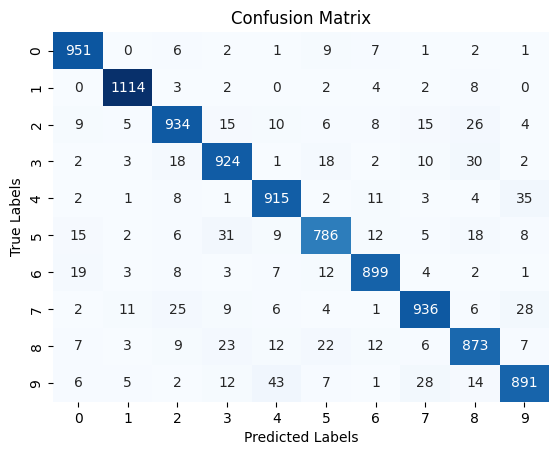

In [9]:
# 使用混淆矩阵查看预测结果

t_preds = predict(t_imgs,w1,b1,w2,b2)
cm = confusion_matrix(t_labels,t_preds)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=False)
# plt.gca().invert_yaxis() # 使y坐标反向
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

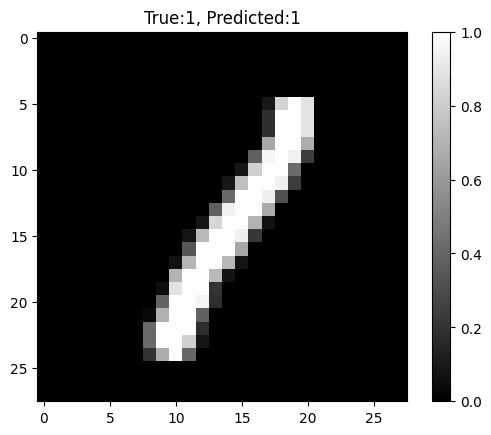

In [10]:
index = np.random.randint(0,10000)
preds = predict(t_imgs[index],w1,b1,w2,b2)[0]
show_img(t_imgs,t_labels,preds,index)

In [11]:
# opencv 手绘预测

import cv2

def draw(event,x,y,flags,param):
    global ix,iy,drawing
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y
    elif event ==cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.circle(m_img,(x,y),25,(255,255,255),-1)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
    elif event == cv2.EVENT_RBUTTONDOWN:
        m_img[:,:] = 0

m_img = np.zeros((512,512,3),dtype=np.uint8)
cv2.namedWindow('image')
cv2.setMouseCallback('image',draw)
drawing = False

while True:
    gm_img = cv2.cvtColor(m_img,cv2.COLOR_BGR2GRAY)
    cv2.imshow('image',gm_img)
    res = cv2.resize(gm_img,(28,28),interpolation=cv2.INTER_AREA)
    # cv2.imshow('res',res)
    res = res.reshape(1,28*28)
    cv2.setWindowTitle('image','predicted num:' + str(predict(res,w1,b1,w2,b2)[0]))
    if cv2.waitKey(1) & 0xFF == 27:
        break

cv2.destroyAllWindows()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12688\3049634370.py:40: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [55]:
cv2.destroyAllWindows()